In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

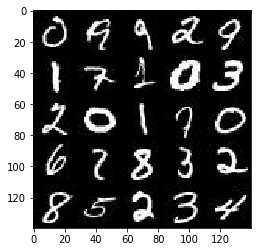

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

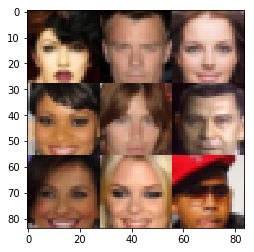

In [3]:
show_n_images = 15

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    input_z=tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learn_rate=tf.placeholder(tf.float32,name="learn_rate")
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)


Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, reuse=False, alpha=0.2):
    
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        #print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 1, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        #print(x3.shape)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same')
        # 32x32x3 now
        #print(logits.shape)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
   
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    vars = tf.trainable_variables()
    d_vars = [var for var in vars if var.name.startswith('discriminator')]
    g_vars = [var for var in vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    #with tf.control_dependencies(tf.get_collection(d_update_ops):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #tf.reset_default_graph()

    input_real, input_z, learn_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])    
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_rate:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))


                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)

                   

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.4900... Generator Loss: 0.0022
Epoch 1/2... Discriminator Loss: 7.8788... Generator Loss: 0.0017
Epoch 1/2... Discriminator Loss: 8.1655... Generator Loss: 0.0005
Epoch 1/2... Discriminator Loss: 3.8425... Generator Loss: 0.0309
Epoch 1/2... Discriminator Loss: 2.8670... Generator Loss: 0.0968
Epoch 1/2... Discriminator Loss: 2.1358... Generator Loss: 0.2107
Epoch 1/2... Discriminator Loss: 2.3105... Generator Loss: 0.2396
Epoch 1/2... Discriminator Loss: 2.9485... Generator Loss: 3.0967
Epoch 1/2... Discriminator Loss: 1.8446... Generator Loss: 0.2546
Epoch 1/2... Discriminator Loss: 1.7070... Generator Loss: 0.2987


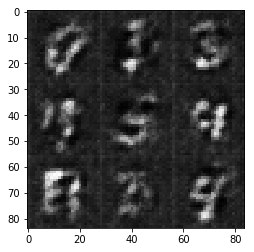

Epoch 1/2... Discriminator Loss: 1.5427... Generator Loss: 0.5006
Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.4426
Epoch 1/2... Discriminator Loss: 1.7098... Generator Loss: 0.2885
Epoch 1/2... Discriminator Loss: 2.1838... Generator Loss: 0.1430
Epoch 1/2... Discriminator Loss: 1.9851... Generator Loss: 2.9189
Epoch 1/2... Discriminator Loss: 1.4169... Generator Loss: 0.4232
Epoch 1/2... Discriminator Loss: 2.0977... Generator Loss: 0.1546
Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 1.0873
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 0.4957
Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 0.6882


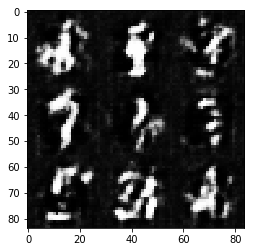

Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 1.5310
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.3812
Epoch 1/2... Discriminator Loss: 1.5632... Generator Loss: 1.9175
Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 0.3189
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 0.4994
Epoch 1/2... Discriminator Loss: 1.2522... Generator Loss: 0.5675
Epoch 1/2... Discriminator Loss: 1.6232... Generator Loss: 0.3200
Epoch 1/2... Discriminator Loss: 1.5448... Generator Loss: 0.2903
Epoch 1/2... Discriminator Loss: 2.4928... Generator Loss: 0.1273
Epoch 1/2... Discriminator Loss: 1.9419... Generator Loss: 0.2154


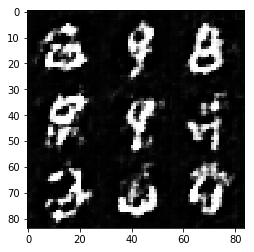

Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 0.4162
Epoch 1/2... Discriminator Loss: 1.3892... Generator Loss: 0.3746
Epoch 1/2... Discriminator Loss: 1.1595... Generator Loss: 0.5792
Epoch 1/2... Discriminator Loss: 1.6105... Generator Loss: 0.3115
Epoch 1/2... Discriminator Loss: 2.0457... Generator Loss: 0.1888
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.3318... Generator Loss: 1.0040
Epoch 1/2... Discriminator Loss: 0.8863... Generator Loss: 1.5467
Epoch 1/2... Discriminator Loss: 2.0256... Generator Loss: 0.2080
Epoch 1/2... Discriminator Loss: 1.8802... Generator Loss: 3.1561


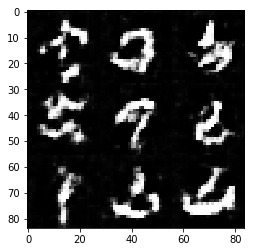

Epoch 1/2... Discriminator Loss: 1.6345... Generator Loss: 0.3434
Epoch 1/2... Discriminator Loss: 1.7299... Generator Loss: 0.2679
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 2.1294... Generator Loss: 0.1437
Epoch 1/2... Discriminator Loss: 1.8969... Generator Loss: 0.2720
Epoch 1/2... Discriminator Loss: 1.4480... Generator Loss: 0.3565
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.5492
Epoch 1/2... Discriminator Loss: 2.2118... Generator Loss: 0.1587
Epoch 1/2... Discriminator Loss: 1.5874... Generator Loss: 0.3326
Epoch 1/2... Discriminator Loss: 1.5600... Generator Loss: 0.2998


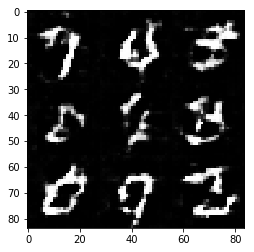

Epoch 1/2... Discriminator Loss: 1.5579... Generator Loss: 0.3380
Epoch 1/2... Discriminator Loss: 1.6955... Generator Loss: 0.2884
Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 0.6707
Epoch 1/2... Discriminator Loss: 2.1828... Generator Loss: 0.1542
Epoch 1/2... Discriminator Loss: 1.7692... Generator Loss: 0.3278
Epoch 1/2... Discriminator Loss: 1.6790... Generator Loss: 0.3045
Epoch 1/2... Discriminator Loss: 1.6135... Generator Loss: 0.3460
Epoch 1/2... Discriminator Loss: 2.6636... Generator Loss: 0.1140
Epoch 1/2... Discriminator Loss: 1.5321... Generator Loss: 0.3552
Epoch 1/2... Discriminator Loss: 1.8558... Generator Loss: 0.2367


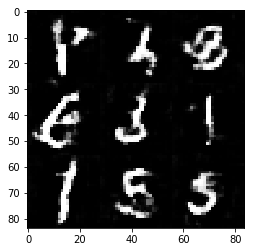

Epoch 1/2... Discriminator Loss: 1.8282... Generator Loss: 0.2637
Epoch 1/2... Discriminator Loss: 0.8451... Generator Loss: 0.8734
Epoch 1/2... Discriminator Loss: 1.7075... Generator Loss: 0.3505
Epoch 1/2... Discriminator Loss: 1.7455... Generator Loss: 0.3964
Epoch 1/2... Discriminator Loss: 1.7741... Generator Loss: 0.2556
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.4148
Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 0.4950
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.3824
Epoch 1/2... Discriminator Loss: 2.4544... Generator Loss: 0.1269
Epoch 1/2... Discriminator Loss: 2.9601... Generator Loss: 0.0864


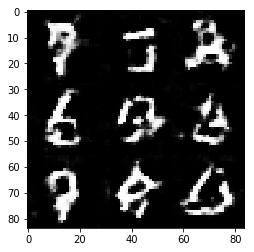

Epoch 1/2... Discriminator Loss: 1.6832... Generator Loss: 0.4185
Epoch 1/2... Discriminator Loss: 1.1575... Generator Loss: 0.5549
Epoch 1/2... Discriminator Loss: 1.7547... Generator Loss: 0.3208
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.8863... Generator Loss: 0.2513
Epoch 1/2... Discriminator Loss: 2.3800... Generator Loss: 0.1327
Epoch 1/2... Discriminator Loss: 2.0323... Generator Loss: 0.2343
Epoch 1/2... Discriminator Loss: 2.2064... Generator Loss: 0.1956
Epoch 1/2... Discriminator Loss: 2.2128... Generator Loss: 0.1748
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.6674


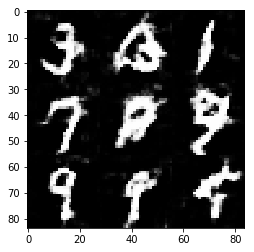

Epoch 1/2... Discriminator Loss: 1.4160... Generator Loss: 0.3876
Epoch 1/2... Discriminator Loss: 1.0537... Generator Loss: 0.7642
Epoch 1/2... Discriminator Loss: 1.7753... Generator Loss: 0.2728
Epoch 1/2... Discriminator Loss: 1.6963... Generator Loss: 0.3765
Epoch 1/2... Discriminator Loss: 1.7843... Generator Loss: 0.3808
Epoch 1/2... Discriminator Loss: 1.9592... Generator Loss: 0.2234
Epoch 1/2... Discriminator Loss: 2.1173... Generator Loss: 0.1810
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.5175
Epoch 1/2... Discriminator Loss: 1.3158... Generator Loss: 0.5314
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 0.5396


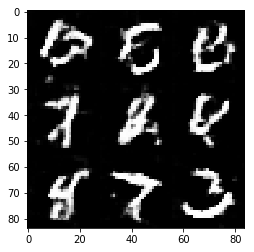

Epoch 1/2... Discriminator Loss: 1.9586... Generator Loss: 0.2716
Epoch 1/2... Discriminator Loss: 1.6411... Generator Loss: 0.2612
Epoch 1/2... Discriminator Loss: 1.6205... Generator Loss: 0.3778
Epoch 1/2... Discriminator Loss: 1.4802... Generator Loss: 1.7435
Epoch 1/2... Discriminator Loss: 2.0629... Generator Loss: 0.2022
Epoch 1/2... Discriminator Loss: 1.2745... Generator Loss: 0.7164
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.5237
Epoch 1/2... Discriminator Loss: 1.4375... Generator Loss: 0.4336
Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 0.4717
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.5278


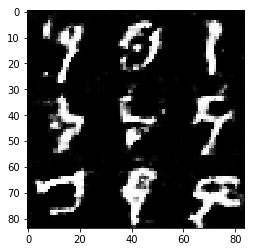

Epoch 1/2... Discriminator Loss: 1.6674... Generator Loss: 0.3281
Epoch 1/2... Discriminator Loss: 1.2495... Generator Loss: 0.7029
Epoch 1/2... Discriminator Loss: 1.4667... Generator Loss: 0.3855
Epoch 1/2... Discriminator Loss: 2.1372... Generator Loss: 0.2104
Epoch 1/2... Discriminator Loss: 1.8089... Generator Loss: 0.4414
Epoch 1/2... Discriminator Loss: 1.8990... Generator Loss: 0.2779
Epoch 1/2... Discriminator Loss: 2.1599... Generator Loss: 0.1833
Epoch 1/2... Discriminator Loss: 2.1598... Generator Loss: 0.1679
Epoch 1/2... Discriminator Loss: 0.6771... Generator Loss: 1.1787
Epoch 1/2... Discriminator Loss: 1.1371... Generator Loss: 0.6537


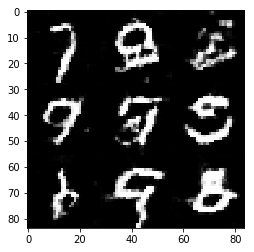

Epoch 1/2... Discriminator Loss: 2.0541... Generator Loss: 0.2236
Epoch 1/2... Discriminator Loss: 1.7919... Generator Loss: 0.3252
Epoch 1/2... Discriminator Loss: 1.7973... Generator Loss: 0.2736
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 0.6102
Epoch 1/2... Discriminator Loss: 1.6007... Generator Loss: 0.4142
Epoch 1/2... Discriminator Loss: 1.1823... Generator Loss: 0.5076
Epoch 1/2... Discriminator Loss: 1.9408... Generator Loss: 0.3616
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 2.2403... Generator Loss: 0.2120
Epoch 1/2... Discriminator Loss: 1.6261... Generator Loss: 0.4435


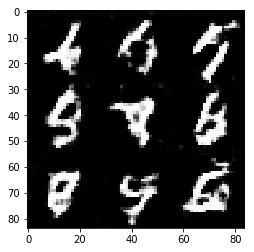

Epoch 2/2... Discriminator Loss: 1.1793... Generator Loss: 0.5758
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.6417
Epoch 2/2... Discriminator Loss: 1.6491... Generator Loss: 0.3749
Epoch 2/2... Discriminator Loss: 2.0944... Generator Loss: 0.3026
Epoch 2/2... Discriminator Loss: 1.2604... Generator Loss: 0.4860
Epoch 2/2... Discriminator Loss: 2.2255... Generator Loss: 0.1682
Epoch 2/2... Discriminator Loss: 1.2612... Generator Loss: 0.4543
Epoch 2/2... Discriminator Loss: 1.3438... Generator Loss: 0.6772
Epoch 2/2... Discriminator Loss: 1.9986... Generator Loss: 0.2370
Epoch 2/2... Discriminator Loss: 0.7191... Generator Loss: 1.2707


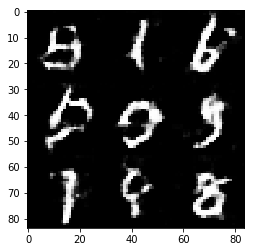

Epoch 2/2... Discriminator Loss: 1.9613... Generator Loss: 0.2594
Epoch 2/2... Discriminator Loss: 1.4575... Generator Loss: 0.4717
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 0.7907
Epoch 2/2... Discriminator Loss: 1.4084... Generator Loss: 0.5084
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 0.5771
Epoch 2/2... Discriminator Loss: 1.9313... Generator Loss: 0.2722
Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 0.5103
Epoch 2/2... Discriminator Loss: 0.5486... Generator Loss: 1.8191
Epoch 2/2... Discriminator Loss: 1.5905... Generator Loss: 0.3706
Epoch 2/2... Discriminator Loss: 1.6682... Generator Loss: 0.4764


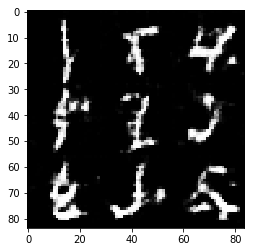

Epoch 2/2... Discriminator Loss: 0.5476... Generator Loss: 1.4605
Epoch 2/2... Discriminator Loss: 1.2623... Generator Loss: 0.5255
Epoch 2/2... Discriminator Loss: 1.2123... Generator Loss: 0.5760
Epoch 2/2... Discriminator Loss: 1.1014... Generator Loss: 0.5814
Epoch 2/2... Discriminator Loss: 1.5131... Generator Loss: 0.3720
Epoch 2/2... Discriminator Loss: 1.2218... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 2.0332... Generator Loss: 0.2599
Epoch 2/2... Discriminator Loss: 0.9609... Generator Loss: 0.6792
Epoch 2/2... Discriminator Loss: 1.1167... Generator Loss: 0.7142
Epoch 2/2... Discriminator Loss: 1.8457... Generator Loss: 0.3192


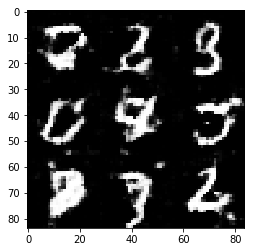

Epoch 2/2... Discriminator Loss: 1.4200... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 0.8229... Generator Loss: 1.1432
Epoch 2/2... Discriminator Loss: 2.5672... Generator Loss: 0.1319
Epoch 2/2... Discriminator Loss: 1.9800... Generator Loss: 0.2124
Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 0.8521
Epoch 2/2... Discriminator Loss: 1.2681... Generator Loss: 0.4581
Epoch 2/2... Discriminator Loss: 1.5043... Generator Loss: 0.3930
Epoch 2/2... Discriminator Loss: 1.1879... Generator Loss: 0.5677
Epoch 2/2... Discriminator Loss: 1.9436... Generator Loss: 0.2436
Epoch 2/2... Discriminator Loss: 1.6455... Generator Loss: 0.4471


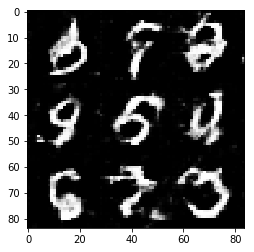

Epoch 2/2... Discriminator Loss: 0.7911... Generator Loss: 1.1422
Epoch 2/2... Discriminator Loss: 1.7725... Generator Loss: 0.4224
Epoch 2/2... Discriminator Loss: 2.1241... Generator Loss: 0.1889
Epoch 2/2... Discriminator Loss: 2.4682... Generator Loss: 0.1370
Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 0.7221
Epoch 2/2... Discriminator Loss: 1.7943... Generator Loss: 0.2923
Epoch 2/2... Discriminator Loss: 1.8188... Generator Loss: 0.5660
Epoch 2/2... Discriminator Loss: 2.0035... Generator Loss: 0.2073
Epoch 2/2... Discriminator Loss: 0.7886... Generator Loss: 1.0744
Epoch 2/2... Discriminator Loss: 0.9072... Generator Loss: 1.1913


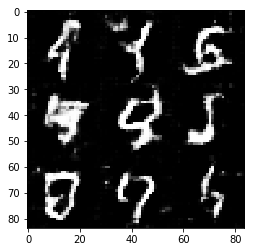

Epoch 2/2... Discriminator Loss: 1.7827... Generator Loss: 0.2941
Epoch 2/2... Discriminator Loss: 1.2776... Generator Loss: 0.4528
Epoch 2/2... Discriminator Loss: 1.8306... Generator Loss: 0.3314
Epoch 2/2... Discriminator Loss: 1.3202... Generator Loss: 0.6203
Epoch 2/2... Discriminator Loss: 1.6678... Generator Loss: 0.3109
Epoch 2/2... Discriminator Loss: 2.8600... Generator Loss: 0.0823
Epoch 2/2... Discriminator Loss: 1.9570... Generator Loss: 0.1981
Epoch 2/2... Discriminator Loss: 0.9810... Generator Loss: 0.7813
Epoch 2/2... Discriminator Loss: 0.6930... Generator Loss: 1.1314
Epoch 2/2... Discriminator Loss: 0.7383... Generator Loss: 0.8413


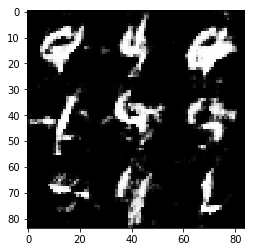

Epoch 2/2... Discriminator Loss: 0.8409... Generator Loss: 0.9277
Epoch 2/2... Discriminator Loss: 1.2361... Generator Loss: 0.6739
Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 1.0950
Epoch 2/2... Discriminator Loss: 1.2760... Generator Loss: 0.6225
Epoch 2/2... Discriminator Loss: 0.4531... Generator Loss: 1.9907
Epoch 2/2... Discriminator Loss: 1.8823... Generator Loss: 0.2515
Epoch 2/2... Discriminator Loss: 1.4136... Generator Loss: 0.3992
Epoch 2/2... Discriminator Loss: 1.0676... Generator Loss: 0.8302
Epoch 2/2... Discriminator Loss: 1.6332... Generator Loss: 0.3830
Epoch 2/2... Discriminator Loss: 1.0890... Generator Loss: 0.6521


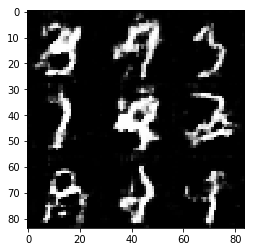

Epoch 2/2... Discriminator Loss: 0.9663... Generator Loss: 1.0101
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.3463
Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.0700
Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 0.9183
Epoch 2/2... Discriminator Loss: 2.2783... Generator Loss: 0.1708
Epoch 2/2... Discriminator Loss: 2.1450... Generator Loss: 0.2399
Epoch 2/2... Discriminator Loss: 3.2866... Generator Loss: 0.0633
Epoch 2/2... Discriminator Loss: 0.7930... Generator Loss: 0.9595
Epoch 2/2... Discriminator Loss: 2.6935... Generator Loss: 0.1516
Epoch 2/2... Discriminator Loss: 3.5376... Generator Loss: 0.0687


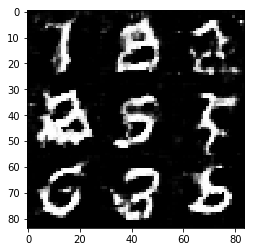

Epoch 2/2... Discriminator Loss: 3.2757... Generator Loss: 0.0858
Epoch 2/2... Discriminator Loss: 0.4401... Generator Loss: 1.6744
Epoch 2/2... Discriminator Loss: 1.1115... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 0.6292... Generator Loss: 1.3380
Epoch 2/2... Discriminator Loss: 0.5022... Generator Loss: 1.2199
Epoch 2/2... Discriminator Loss: 1.2424... Generator Loss: 0.6008
Epoch 2/2... Discriminator Loss: 0.4658... Generator Loss: 1.4722
Epoch 2/2... Discriminator Loss: 1.4069... Generator Loss: 0.5095
Epoch 2/2... Discriminator Loss: 2.0735... Generator Loss: 0.2998
Epoch 2/2... Discriminator Loss: 2.1688... Generator Loss: 0.1757


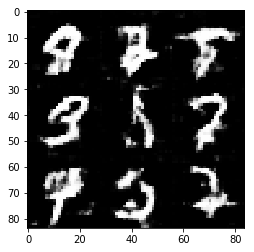

Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 1.2258
Epoch 2/2... Discriminator Loss: 1.1785... Generator Loss: 0.7410
Epoch 2/2... Discriminator Loss: 1.7902... Generator Loss: 0.4434
Epoch 2/2... Discriminator Loss: 2.3720... Generator Loss: 0.2762
Epoch 2/2... Discriminator Loss: 2.0081... Generator Loss: 0.3656
Epoch 2/2... Discriminator Loss: 1.7486... Generator Loss: 0.2859
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.5186
Epoch 2/2... Discriminator Loss: 0.3784... Generator Loss: 1.5392
Epoch 2/2... Discriminator Loss: 0.1965... Generator Loss: 2.1360
Epoch 2/2... Discriminator Loss: 0.7809... Generator Loss: 0.9629


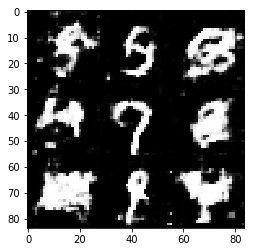

Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 0.6767
Epoch 2/2... Discriminator Loss: 0.8412... Generator Loss: 0.8226
Epoch 2/2... Discriminator Loss: 0.6739... Generator Loss: 1.1548
Epoch 2/2... Discriminator Loss: 1.3731... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 0.9079... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 1.4464... Generator Loss: 0.4304
Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 0.6482
Epoch 2/2... Discriminator Loss: 1.6316... Generator Loss: 0.5337
Epoch 2/2... Discriminator Loss: 2.1976... Generator Loss: 0.2039


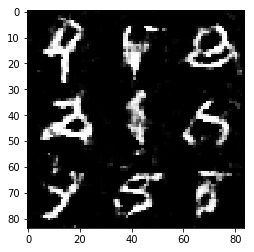

Epoch 2/2... Discriminator Loss: 0.5932... Generator Loss: 1.1575
Epoch 2/2... Discriminator Loss: 0.9560... Generator Loss: 0.7344
Epoch 2/2... Discriminator Loss: 1.8285... Generator Loss: 0.3339
Epoch 2/2... Discriminator Loss: 1.5495... Generator Loss: 0.5812
Epoch 2/2... Discriminator Loss: 1.6747... Generator Loss: 0.5433
Epoch 2/2... Discriminator Loss: 2.3601... Generator Loss: 0.2257
Epoch 2/2... Discriminator Loss: 15.1274... Generator Loss: 0.0000
Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 1.6932
Epoch 2/2... Discriminator Loss: 0.7749... Generator Loss: 0.8116
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 0.7247


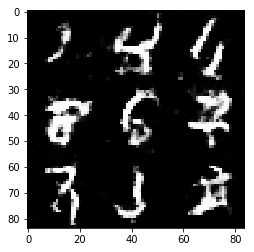

In [15]:
batch_size = 50
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 1.3417
Epoch 1/1... Discriminator Loss: 0.2375... Generator Loss: 2.0090
Epoch 1/1... Discriminator Loss: 0.2927... Generator Loss: 1.6857
Epoch 1/1... Discriminator Loss: 0.2236... Generator Loss: 1.9566
Epoch 1/1... Discriminator Loss: 0.2005... Generator Loss: 2.0907
Epoch 1/1... Discriminator Loss: 0.2018... Generator Loss: 2.0087
Epoch 1/1... Discriminator Loss: 0.2299... Generator Loss: 1.9115
Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 2.1072
Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 3.0983
Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 1.3614


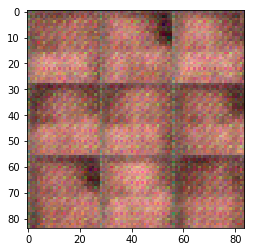

Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 1.6411
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 2.2887
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 1.6413
Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 2.9633
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 1.7849
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 1.5569
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 1.8069
Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 1.6539


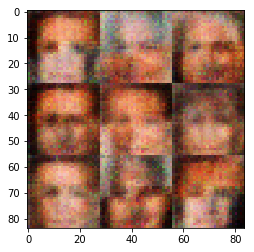

Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 1.7614
Epoch 1/1... Discriminator Loss: 0.4811... Generator Loss: 1.7519
Epoch 1/1... Discriminator Loss: 0.5124... Generator Loss: 1.9689
Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 1.5927
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 2.5934
Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 1.4225
Epoch 1/1... Discriminator Loss: 0.4476... Generator Loss: 2.3642
Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 2.5135
Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 2.2941
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 2.0642


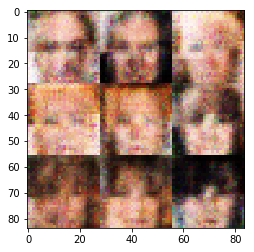

Epoch 1/1... Discriminator Loss: 0.3449... Generator Loss: 2.1079
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 1.9159
Epoch 1/1... Discriminator Loss: 0.2663... Generator Loss: 2.2407
Epoch 1/1... Discriminator Loss: 0.2712... Generator Loss: 2.1301
Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 1.5131
Epoch 1/1... Discriminator Loss: 0.2937... Generator Loss: 2.4679
Epoch 1/1... Discriminator Loss: 0.2269... Generator Loss: 3.1509
Epoch 1/1... Discriminator Loss: 0.2553... Generator Loss: 2.2358
Epoch 1/1... Discriminator Loss: 0.2040... Generator Loss: 2.4866
Epoch 1/1... Discriminator Loss: 0.3204... Generator Loss: 1.9313


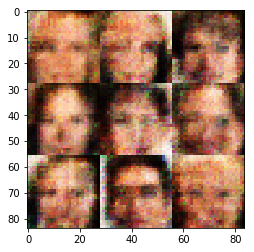

Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 2.2315
Epoch 1/1... Discriminator Loss: 0.2414... Generator Loss: 2.9106
Epoch 1/1... Discriminator Loss: 0.2458... Generator Loss: 2.2569
Epoch 1/1... Discriminator Loss: 0.2008... Generator Loss: 2.4229
Epoch 1/1... Discriminator Loss: 0.2724... Generator Loss: 2.1133
Epoch 1/1... Discriminator Loss: 0.6781... Generator Loss: 3.3833
Epoch 1/1... Discriminator Loss: 0.3034... Generator Loss: 2.0251
Epoch 1/1... Discriminator Loss: 0.4423... Generator Loss: 1.9496
Epoch 1/1... Discriminator Loss: 0.2346... Generator Loss: 2.6886
Epoch 1/1... Discriminator Loss: 0.2400... Generator Loss: 2.0513


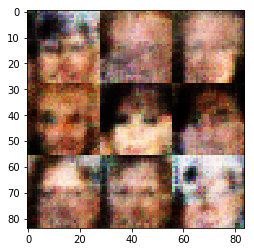

Epoch 1/1... Discriminator Loss: 0.2453... Generator Loss: 2.2934
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 3.1247
Epoch 1/1... Discriminator Loss: 0.1469... Generator Loss: 3.1172
Epoch 1/1... Discriminator Loss: 0.3896... Generator Loss: 1.8580
Epoch 1/1... Discriminator Loss: 0.1848... Generator Loss: 2.8818
Epoch 1/1... Discriminator Loss: 0.2028... Generator Loss: 2.3159
Epoch 1/1... Discriminator Loss: 0.1872... Generator Loss: 2.5782
Epoch 1/1... Discriminator Loss: 0.2887... Generator Loss: 2.2584
Epoch 1/1... Discriminator Loss: 0.2788... Generator Loss: 2.9559
Epoch 1/1... Discriminator Loss: 0.1834... Generator Loss: 2.9654


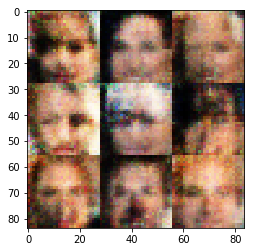

Epoch 1/1... Discriminator Loss: 0.1104... Generator Loss: 3.2149
Epoch 1/1... Discriminator Loss: 0.1307... Generator Loss: 2.9992
Epoch 1/1... Discriminator Loss: 0.2416... Generator Loss: 2.2356
Epoch 1/1... Discriminator Loss: 0.1600... Generator Loss: 2.6409
Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 2.6122
Epoch 1/1... Discriminator Loss: 0.1909... Generator Loss: 2.5433
Epoch 1/1... Discriminator Loss: 0.3016... Generator Loss: 1.9614
Epoch 1/1... Discriminator Loss: 0.2586... Generator Loss: 2.0391
Epoch 1/1... Discriminator Loss: 0.1149... Generator Loss: 3.7526
Epoch 1/1... Discriminator Loss: 0.1473... Generator Loss: 2.8451


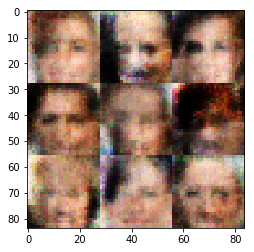

Epoch 1/1... Discriminator Loss: 0.1186... Generator Loss: 3.3714
Epoch 1/1... Discriminator Loss: 0.0813... Generator Loss: 3.5205
Epoch 1/1... Discriminator Loss: 0.0850... Generator Loss: 3.2072
Epoch 1/1... Discriminator Loss: 0.1284... Generator Loss: 3.1131
Epoch 1/1... Discriminator Loss: 0.0895... Generator Loss: 3.3355
Epoch 1/1... Discriminator Loss: 0.0909... Generator Loss: 3.1267
Epoch 1/1... Discriminator Loss: 0.1025... Generator Loss: 3.5767
Epoch 1/1... Discriminator Loss: 0.2458... Generator Loss: 2.1731
Epoch 1/1... Discriminator Loss: 0.0913... Generator Loss: 3.2772
Epoch 1/1... Discriminator Loss: 0.1273... Generator Loss: 2.8845


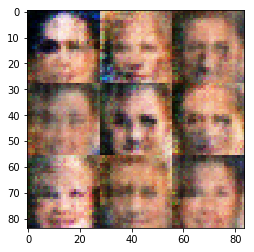

Epoch 1/1... Discriminator Loss: 0.1274... Generator Loss: 2.9770
Epoch 1/1... Discriminator Loss: 0.1684... Generator Loss: 3.0374
Epoch 1/1... Discriminator Loss: 0.1284... Generator Loss: 3.8875
Epoch 1/1... Discriminator Loss: 0.1477... Generator Loss: 2.6693
Epoch 1/1... Discriminator Loss: 0.1801... Generator Loss: 3.0441
Epoch 1/1... Discriminator Loss: 0.1415... Generator Loss: 3.3045
Epoch 1/1... Discriminator Loss: 0.0755... Generator Loss: 3.5796
Epoch 1/1... Discriminator Loss: 0.1367... Generator Loss: 3.0865
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 2.6137
Epoch 1/1... Discriminator Loss: 0.5392... Generator Loss: 6.4184


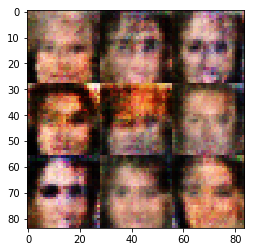

Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 1.7345
Epoch 1/1... Discriminator Loss: 0.0855... Generator Loss: 4.3620
Epoch 1/1... Discriminator Loss: 0.1105... Generator Loss: 3.4745
Epoch 1/1... Discriminator Loss: 0.0695... Generator Loss: 3.6671
Epoch 1/1... Discriminator Loss: 0.1990... Generator Loss: 2.9278
Epoch 1/1... Discriminator Loss: 0.1390... Generator Loss: 3.3208
Epoch 1/1... Discriminator Loss: 0.0611... Generator Loss: 3.8302
Epoch 1/1... Discriminator Loss: 0.1008... Generator Loss: 3.2667
Epoch 1/1... Discriminator Loss: 0.0836... Generator Loss: 3.9833
Epoch 1/1... Discriminator Loss: 0.1742... Generator Loss: 3.0599


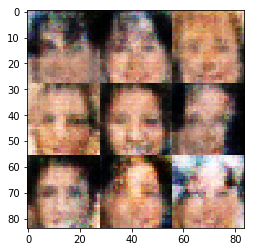

Epoch 1/1... Discriminator Loss: 0.2462... Generator Loss: 2.2306
Epoch 1/1... Discriminator Loss: 0.1228... Generator Loss: 2.8894
Epoch 1/1... Discriminator Loss: 0.1150... Generator Loss: 3.0715
Epoch 1/1... Discriminator Loss: 0.0592... Generator Loss: 4.5352
Epoch 1/1... Discriminator Loss: 0.0365... Generator Loss: 5.2309
Epoch 1/1... Discriminator Loss: 0.0483... Generator Loss: 3.9079
Epoch 1/1... Discriminator Loss: 0.0833... Generator Loss: 3.1309
Epoch 1/1... Discriminator Loss: 0.0526... Generator Loss: 3.9388
Epoch 1/1... Discriminator Loss: 0.0621... Generator Loss: 3.8065
Epoch 1/1... Discriminator Loss: 0.0682... Generator Loss: 4.3303


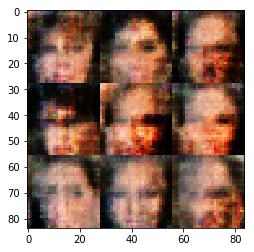

Epoch 1/1... Discriminator Loss: 0.1381... Generator Loss: 2.6254
Epoch 1/1... Discriminator Loss: 0.0548... Generator Loss: 3.3871
Epoch 1/1... Discriminator Loss: 0.0576... Generator Loss: 3.8754
Epoch 1/1... Discriminator Loss: 0.0613... Generator Loss: 3.9412
Epoch 1/1... Discriminator Loss: 0.0341... Generator Loss: 4.1525
Epoch 1/1... Discriminator Loss: 0.0543... Generator Loss: 3.7078
Epoch 1/1... Discriminator Loss: 0.0583... Generator Loss: 3.8530
Epoch 1/1... Discriminator Loss: 0.0756... Generator Loss: 3.7165
Epoch 1/1... Discriminator Loss: 0.0949... Generator Loss: 2.9514
Epoch 1/1... Discriminator Loss: 0.0616... Generator Loss: 3.8606


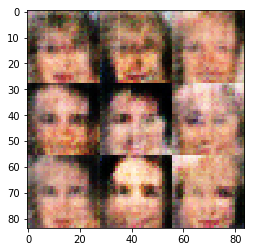

Epoch 1/1... Discriminator Loss: 0.0704... Generator Loss: 3.6130
Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 3.7708
Epoch 1/1... Discriminator Loss: 0.0719... Generator Loss: 3.6492
Epoch 1/1... Discriminator Loss: 0.1497... Generator Loss: 2.6989
Epoch 1/1... Discriminator Loss: 0.1843... Generator Loss: 2.5052
Epoch 1/1... Discriminator Loss: 0.0856... Generator Loss: 3.3073
Epoch 1/1... Discriminator Loss: 0.0235... Generator Loss: 5.8139
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 4.0569
Epoch 1/1... Discriminator Loss: 0.1072... Generator Loss: 3.0898
Epoch 1/1... Discriminator Loss: 0.0248... Generator Loss: 4.9488


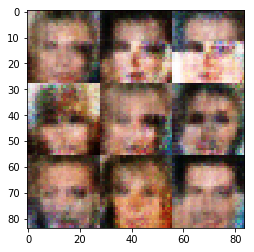

Epoch 1/1... Discriminator Loss: 0.0855... Generator Loss: 3.0500
Epoch 1/1... Discriminator Loss: 0.0510... Generator Loss: 4.0611
Epoch 1/1... Discriminator Loss: 0.1110... Generator Loss: 2.7799
Epoch 1/1... Discriminator Loss: 0.0192... Generator Loss: 4.7891
Epoch 1/1... Discriminator Loss: 0.0453... Generator Loss: 4.0358
Epoch 1/1... Discriminator Loss: 0.0424... Generator Loss: 4.1034
Epoch 1/1... Discriminator Loss: 0.0285... Generator Loss: 4.7815
Epoch 1/1... Discriminator Loss: 0.0272... Generator Loss: 4.2375
Epoch 1/1... Discriminator Loss: 0.0619... Generator Loss: 3.7004
Epoch 1/1... Discriminator Loss: 0.0588... Generator Loss: 3.4978


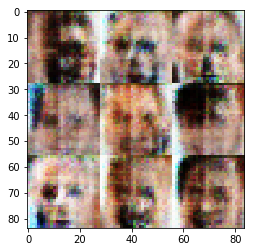

Epoch 1/1... Discriminator Loss: 0.0217... Generator Loss: 5.0341
Epoch 1/1... Discriminator Loss: 0.0431... Generator Loss: 4.4652
Epoch 1/1... Discriminator Loss: 0.0618... Generator Loss: 4.3953
Epoch 1/1... Discriminator Loss: 0.5779... Generator Loss: 4.9005
Epoch 1/1... Discriminator Loss: 0.1407... Generator Loss: 2.6967
Epoch 1/1... Discriminator Loss: 0.0581... Generator Loss: 3.9650
Epoch 1/1... Discriminator Loss: 0.0741... Generator Loss: 3.5220
Epoch 1/1... Discriminator Loss: 0.1191... Generator Loss: 4.5542
Epoch 1/1... Discriminator Loss: 0.0366... Generator Loss: 4.2773
Epoch 1/1... Discriminator Loss: 0.1029... Generator Loss: 3.4024


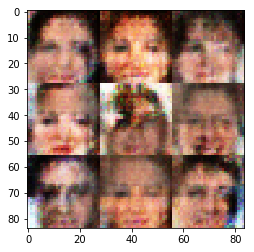

Epoch 1/1... Discriminator Loss: 0.1537... Generator Loss: 2.6889
Epoch 1/1... Discriminator Loss: 0.1340... Generator Loss: 2.8109
Epoch 1/1... Discriminator Loss: 0.1901... Generator Loss: 2.6528
Epoch 1/1... Discriminator Loss: 0.1019... Generator Loss: 3.1370
Epoch 1/1... Discriminator Loss: 0.0830... Generator Loss: 3.5041
Epoch 1/1... Discriminator Loss: 0.0577... Generator Loss: 3.4517
Epoch 1/1... Discriminator Loss: 0.0378... Generator Loss: 4.4823
Epoch 1/1... Discriminator Loss: 0.0434... Generator Loss: 3.7750
Epoch 1/1... Discriminator Loss: 0.0293... Generator Loss: 4.4408
Epoch 1/1... Discriminator Loss: 0.0276... Generator Loss: 4.7375


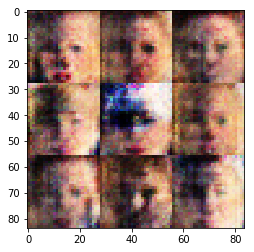

Epoch 1/1... Discriminator Loss: 0.0118... Generator Loss: 5.7000
Epoch 1/1... Discriminator Loss: 0.0250... Generator Loss: 4.7351
Epoch 1/1... Discriminator Loss: 0.0566... Generator Loss: 4.1466
Epoch 1/1... Discriminator Loss: 0.0513... Generator Loss: 4.1308
Epoch 1/1... Discriminator Loss: 0.0595... Generator Loss: 3.5388
Epoch 1/1... Discriminator Loss: 0.0410... Generator Loss: 5.1674
Epoch 1/1... Discriminator Loss: 0.0204... Generator Loss: 5.3296
Epoch 1/1... Discriminator Loss: 0.0593... Generator Loss: 4.2745
Epoch 1/1... Discriminator Loss: 0.0116... Generator Loss: 5.8683
Epoch 1/1... Discriminator Loss: 0.0659... Generator Loss: 3.9430


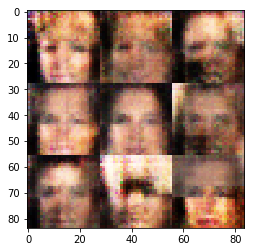

Epoch 1/1... Discriminator Loss: 0.0615... Generator Loss: 3.7231
Epoch 1/1... Discriminator Loss: 0.1613... Generator Loss: 2.7283
Epoch 1/1... Discriminator Loss: 0.0192... Generator Loss: 5.6750
Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 4.0945
Epoch 1/1... Discriminator Loss: 0.0378... Generator Loss: 3.8871
Epoch 1/1... Discriminator Loss: 0.0585... Generator Loss: 4.0246
Epoch 1/1... Discriminator Loss: 0.0499... Generator Loss: 3.4700
Epoch 1/1... Discriminator Loss: 0.0807... Generator Loss: 3.8446
Epoch 1/1... Discriminator Loss: 0.0388... Generator Loss: 4.4914
Epoch 1/1... Discriminator Loss: 0.0280... Generator Loss: 5.2304


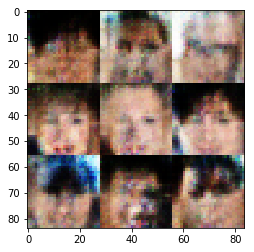

Epoch 1/1... Discriminator Loss: 0.0646... Generator Loss: 3.6450
Epoch 1/1... Discriminator Loss: 0.0213... Generator Loss: 5.2590
Epoch 1/1... Discriminator Loss: 0.0246... Generator Loss: 4.5735
Epoch 1/1... Discriminator Loss: 0.0601... Generator Loss: 3.8631
Epoch 1/1... Discriminator Loss: 0.0302... Generator Loss: 4.4410
Epoch 1/1... Discriminator Loss: 0.0215... Generator Loss: 4.6137
Epoch 1/1... Discriminator Loss: 0.0260... Generator Loss: 4.3133
Epoch 1/1... Discriminator Loss: 0.0563... Generator Loss: 3.6929
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 3.3545
Epoch 1/1... Discriminator Loss: 0.0496... Generator Loss: 3.3668


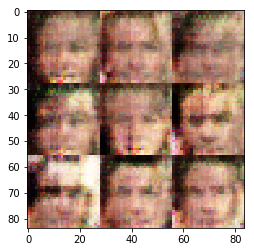

Epoch 1/1... Discriminator Loss: 0.0453... Generator Loss: 3.9128
Epoch 1/1... Discriminator Loss: 0.0172... Generator Loss: 4.8015
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 6.6084
Epoch 1/1... Discriminator Loss: 0.0158... Generator Loss: 4.7255
Epoch 1/1... Discriminator Loss: 0.0256... Generator Loss: 4.6098
Epoch 1/1... Discriminator Loss: 0.0472... Generator Loss: 5.6331
Epoch 1/1... Discriminator Loss: 0.0336... Generator Loss: 4.1299
Epoch 1/1... Discriminator Loss: 0.0325... Generator Loss: 4.5026
Epoch 1/1... Discriminator Loss: 0.0481... Generator Loss: 3.9650
Epoch 1/1... Discriminator Loss: 0.0571... Generator Loss: 3.5730


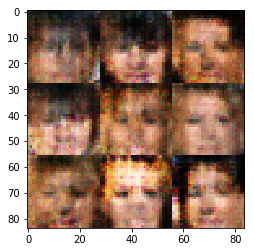

Epoch 1/1... Discriminator Loss: 0.0440... Generator Loss: 3.6153
Epoch 1/1... Discriminator Loss: 0.0917... Generator Loss: 3.2118


In [13]:
batch_size = 100
z_dim = 10
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.